# Trash Haulers Project - Null & Void Waste Solutions

## Import Libraries

In [1]:
#from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

## Read in CSV

In [2]:
trash = pd.read_csv('trash_hauler_report.csv')

## EDA

In [3]:
trash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Request Number    20226 non-null  int64  
 1   Date Opened       20226 non-null  object 
 2   Request           20226 non-null  object 
 3   Description       20195 non-null  object 
 4   Incident Address  20217 non-null  object 
 5   Zip Code          20151 non-null  float64
 6   Trash Hauler      19325 non-null  object 
 7   Trash Route       19279 non-null  object 
 8   Council District  20177 non-null  float64
 9   State Plan X      20198 non-null  float64
 10  State Plan Y      20198 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.7+ MB


In [4]:
trash.describe()

,Request Number,Zip Code,Council District,State Plan X,State Plan Y
count,20226.000000,20151.000000,20177.000000,2.019800e+04,2.019800e+04
mean,149178.986354,37180.621805,18.079100,1.763012e+06,6.595069e+05
std,71837.306889,66.310919,9.917632,7.754951e+05,4.355405e+04
min,25270.000000,37013.000000,1.000000,1.663490e+06,-2.719106e+05
25%,86052.750000,37205.000000,8.000000,1.727831e+06,6.406542e+05
50%,145223.500000,37209.000000,19.000000,1.745845e+06,6.564858e+05
75%,217162.750000,37214.000000,26.000000,1.759491e+06,6.756736e+05
max,267137.000000,37228.000000,35.000000,3.496892e+07,2.204382e+06


In [10]:
trash['Request Number'].is_unique

True

## Clean DataFrame

### Remove whitespace from column headers

In [23]:
# remove whitespace from column headers
trash.columns = trash.columns.str.strip()

### 'Date Opened' to datetime

In [32]:
# 'Date Opened' to datetime
trash['Date Opened'] = pd.to_datetime(trash['Date Opened'], format='%Y/%m/%d', errors='coerce')
# checking if there are any timestamps (came back false)
# (trash['Date Opened'].dt.time != pd.to_datetime('00:00:00').time()).any()
# datetime type dtype('<M8[ns]') which is also datetime64[ns]
# trash['Date Opened'].dtype
# Adding columns from datetime
trash['Year']  = trash['Date Opened'].dt.year
trash['Month'] = trash['Date Opened'].dt.month
trash['Day']   = trash['Date Opened'].dt.day
trash['Weekday'] = trash['Date Opened'].dt.day_name()
# view new columns
trash.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,Year,Month,Day,Weekday
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1.727970e+06,686779.478089,2017,11,1,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1.721259e+06,685444.799565,2017,11,1,Wednesday


## Create Filters for First Question: Red River Missed Pickups

In [41]:
missed_categories = ['Trash - Backdoor', 'Trash - Curbside/Alley Missed Pickup'] # these are the categories that are, by definition, missed pickups on the website
# we could also add some regex here on type 'Trash Collection Complaint' to pick up language that identifies a missing pickup
rrmissed = trash[(trash['Trash Hauler'] == 'RED RIVER') & (trash['Request'].isin(missed_categories))].copy() # filter on Red River & missed_categories
len(rrmissed) # should be 12911 to match Excel filters

12911

In [42]:
# found one (1) row with a missing address in Excel rrmissed filters
rrmissed = rrmissed.dropna(subset=['Incident Address'])
len(rrmissed) # should be 12910

12910

## What should we do about same day (or same week) requests?
- if trash is picked up weekly, and somebody put in 10 missing pickup tickets during the week, should that only count as one missed pickup?
- explore Excel for example and troubleshoot

## Create an address key? Something we can use to find same addresses

In [39]:
# this is going to involve regex

## Testing what to convert the X/Y coordinates to for mapping

In [28]:
import geopandas as gpd

# Create a GeoDataFrame from your existing df
gdf = gpd.GeoDataFrame(
    trash.copy(),
    geometry=gpd.points_from_xy(trash['State Plan X'], trash['State Plan Y']),
    crs="EPSG:2274"   # or "EPSG:6576" if NAD83(2011)
)

# Reproject to WGS84 (lat/lon)
gdf_ll = gdf.to_crs(epsg=4326)

# Extract numeric lon/lat columns if you want them separately
gdf_ll['lon'] = gdf_ll.geometry.x
gdf_ll['lat'] = gdf_ll.geometry.y

# Preview results
print(gdf_ll[['State Plan X', 'State Plan Y', 'lon', 'lat']].head())


   State Plan X   State Plan Y        lon        lat
0  1.727970e+06  686779.478089 -86.815392  36.217292
1  1.721259e+06  685444.799565 -86.838103  36.213470
2  1.707027e+06  659887.471571 -86.885562  36.142923
3  1.735692e+06  685027.245923 -86.789170  36.212652
4  1.710186e+06  664205.101066 -86.874995  36.154861


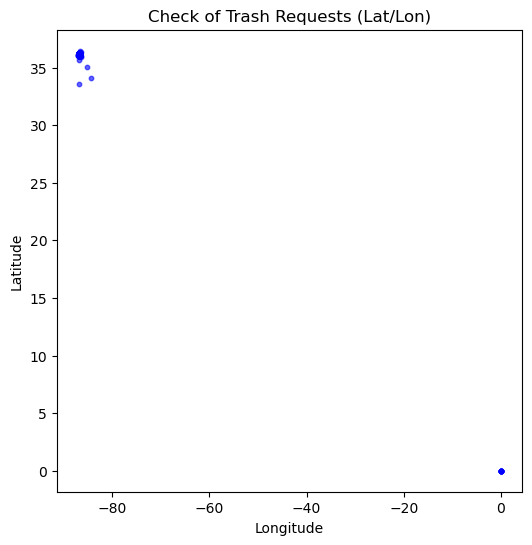

In [31]:
import matplotlib.pyplot as plt

# assuming you already did:
# gdf = gpd.GeoDataFrame(..., crs="EPSG:2274")
# gdf_ll = gdf.to_crs(epsg=4326)

plt.figure(figsize=(6,6))
plt.scatter(gdf_ll['lon'], gdf_ll['lat'], s=10, c='blue', alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Check of Trash Requests (Lat/Lon)")

plt.show()

### need to remove NaNs in X/Y coordinates prior to mapping